<p style="background-color:lightgreen;font-family:newtimeroman;font-size:22px;line-height:1.7em;text-align:center;border-radius:5px 5px">Email Spam Detection using Natural Language Processing</p>

In [1]:
# Importing required Libraries 
import string
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
# Loading data
messages = pd.read_csv(r'C:\PYTHON\AI_ML\Machine_Learning_Projects\smsspamcollection\smsspamcollection1.csv')
messages

,Column1,Column2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [3]:
# Rename names columns 
messages.columns = ['label', 'messages']

In [4]:
messages.head(3)

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


### Exploratory Data Analysis

In [5]:
# Getting Data Shape
messages.shape

(5574, 2)

In [6]:
# Getting Metadata Info
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5574 non-null   object
 1   messages  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# Getting Data description
messages.describe()

,label,messages
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


Note that our data contains a collection of 5574 SMS and also we have only 2 label: ham and spam. Now, we create a column called ‘length’ to know how long the text messages are and then plot it against the label:

In [8]:
messages["length"] = messages["messages"].apply(len)
messages.sort_values(by='length', ascending=False).head(10)

,label,messages,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629
1579,ham,How to Make a girl Happy? It's not at all diff...,611
2849,ham,Sad story of a Man - Last week was my b'day. M...,588
2158,ham,Sad story of a Man - Last week was my b'day. M...,588
2380,ham,"Good evening Sir, hope you are having a nice d...",482
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461
1513,ham,"Hey sweet, I was wondering when you had a mome...",458
2370,ham,A Boy loved a gal. He propsd bt she didnt mind...,446


ham     4827
spam     747
Name: label, dtype: int64




<AxesSubplot:ylabel='label'>

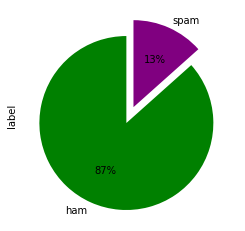

In [9]:
# Getting percentage on label count
print(messages["label"].value_counts())
print("\n")
explode = [0.1, 0.1]
cs = ['green','purple']
messages["label"].value_counts().plot(kind='pie',startangle=90, autopct='%.0f%%',explode=explode, colors=cs)

### Remove all punctuation

In [10]:
def text_preprocess(message):
    # Remove punctuations
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again
    nopunc = "".join(nopunc)
    nopunc = nopunc.lower()

    # Remove any stopwords and non-alphabetic characters
    nostop = [
        word
        for word in nopunc.split()
        if word.lower() not in stopwords.words("english") and word.isalpha()
    ]

    return nostop

In [11]:
# Let's see how many spam and ham (non-spam) messages constitute our dataset.
spam_messages = messages[messages["label"] == "spam"]["messages"]
ham_messages = messages[messages["label"] == "ham"]["messages"]
print(f"Number of spam messages: {len(spam_messages)}")
print(f"Number of ham messages: {len(ham_messages)}")

Number of spam messages: 747
Number of ham messages: 4827


In [12]:
# Next, we check the top ten words that repeat the most in both ham and spam messages. 

# Words in spam messages
spam_words = []
for each_message in spam_messages:
    spam_words += text_preprocess(each_message)
    
print(f"Top 10 spam words are:\n {pd.Series(spam_words).value_counts().head(10)}")

Top 10 spam words are:
 call      347
free      216
txt       150
u         147
ur        144
mobile    123
text      120
stop      115
claim     113
reply     101
dtype: int64


In [13]:
# Words in ham messages
ham_words = []
for each_message in ham_messages:
    ham_words += text_preprocess(each_message)
    
print(f"Top 10 ham words are:\n {pd.Series(ham_words).value_counts().head(10)}")

Top 10 ham words are:
 u       985
im      451
get     303
ltgt    276
ok      273
dont    265
go      250
ur      246
ill     238
got     232
dtype: int64


In [14]:
# Remove punctuations/stopwords from all messages
messages["messages"] = messages["messages"].apply(text_preprocess)
messages.head()

,label,messages,length
0,ham,"[go, jurong, point, crazy, available, bugis, n...",111
1,ham,"[ok, lar, joking, wif, u, oni]",29
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,...",155
3,ham,"[u, dun, say, early, hor, u, c, already, say]",49
4,ham,"[nah, dont, think, goes, usf, lives, around, t...",61


In [15]:
# Convert messages (as lists of string tokens) to strings
messages["messages"] = messages["messages"].agg(lambda x: " ".join(map(str, x)))
messages.head()

,label,messages,length
0,ham,go jurong point crazy available bugis n great ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry wkly comp win fa cup final tkts may...,155
3,ham,u dun say early hor u c already say,49
4,ham,nah dont think goes usf lives around though,61


### The Bag of Words Approach

In [16]:
# Initialize count vectorizer
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(messages["messages"])

# Fetch the vocabulary set
print(f"20 BOW Features: {vectorizer.get_feature_names()[20:40]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

20 BOW Features: ['absence', 'absolutely', 'abstract', 'abt', 'abta', 'aburo', 'abuse', 'abusers', 'ac', 'academic', 'acc', 'accent', 'accenture', 'accept', 'access', 'accessible', 'accidant', 'accident', 'accidentally', 'accommodation']
Total number of vocab words: 8134


C:\Users\VENKATESH MUNGI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
# Convert strings to vectors using BoW
messages_bow = bow_transformer.transform(messages["messages"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {messages_bow.shape}")
print(f"Amount of non-zero occurrences: {messages_bow.nnz}")

Shape of sparse matrix: (5574, 8134)
Amount of non-zero occurrences: 44390


### The TF-IDF Approach

In [18]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

# Transform entire BoW into tf-idf corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 8134)


### Train Test Splitting

In [19]:
# Convert spam and ham labels to 0 and 1 (or, vice-versa)
FactorResult = pd.factorize(messages["label"])
messages["label"] = FactorResult[0]
messages.head()

,label,messages,length
0,0,go jurong point crazy available bugis n great ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry wkly comp win fa cup final tkts may...,155
3,0,u dun say early hor u c already say,49
4,0,nah dont think goes usf lives around though,61


In [20]:
# Split the dataset to train and test sets
x_train, x_test, y_train, y_test = train_test_split(messages_tfidf, messages["label"], test_size=0.2)

print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")

print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (4459, 8134)
train dataset label size: (4459,)
test dataset features size: (1115, 8134)
test dataset label size: (1115,)


### Building XGBoost Model

In [21]:
# Train an xgboost classifier
from xgboost import XGBClassifier

In [22]:
# Instantiate our model
clf = XGBClassifier()

# Fit the model to the training data
clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
# Make predictions on the training dataset.
predict_train = clf.predict(x_train)
print(f"Accuracy of Train dataset: {metrics.accuracy_score(y_train, predict_train):0.3f}")

Accuracy of Train dataset: 0.988


In [24]:
# To get an essence of how our model fared, let’s do an example prediction.
print("predicted:",clf.predict(tfidf_transformer.transform(bow_transformer.transform([messages["messages"][9]])))[0],)
print("expected:", messages["label"][9])

predicted: 1
expected: 1


And yes, it worked!

Finally, we find the overall accuracy of the model on the test data.

In [25]:
# print the overall accuracy of the model
label_predictions = clf.predict(x_test)
print(f"Accuracy of the model: {metrics.accuracy_score(y_test, label_predictions):0.3f}")

Accuracy of the model: 0.974


### Real Time Prediction

In [26]:
import joblib
dump = joblib.dump(clf, 'spam_checker.pkl')

In [27]:
load = joblib.load('spam_checker.pkl')

In [28]:
final = load.predict(x_test[31])
final

array([0])

### METHOD2: Saving entire process into Single Pipe Line.

In [29]:
# Create a classifier in pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
sentiment_classifier = Pipeline(steps=[('pre_processing',tfidf_transformer),('xgb',XGBClassifier())])

In [30]:
# train the sentiment classifier 
sentiment_classifier.fit(x_train,y_train)

Pipeline(steps=[('pre_processing', TfidfTransformer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [31]:
# test model performance on valid data 
y_preds = sentiment_classifier.predict(x_test)
y_preds

array([0, 0, 0, ..., 0, 0, 1])

In [32]:
from sklearn.metrics import (accuracy_score,classification_report,plot_confusion_matrix)
accuracy_score(y_test,y_preds)

0.9721973094170404

In [33]:
score_report = classification_report(y_test,y_preds)
print(score_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       968
           1       0.93      0.85      0.89       147

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



### Real Time Prediction2

In [34]:
dump1 = joblib.dump(sentiment_classifier, 'spam_checker1.pkl')

In [35]:
load1 = joblib.load('spam_checker1.pkl')

In [36]:
final2 = load1.predict(x_test[51])
final2

array([0])

In [37]:
# Reference : https://blog.paperspace.com/nlp-spam-detection-application-with-scikitlearn-xgboost/